In [218]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [382]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from helper_functions import create_tf_data_datasets
from helper_functions import plot_triplet_roc_curve_2
from helper_functions import plot_triplet_training
from helper_functions import create_tf_data_datasets_contrastive
from helper_functions import contrastive_loss
from helper_functions import euclidean_distance
from helper_functions import triplet_loss_l2
from helper_functions import create_tf_data_testset_contrastive
from helper_functions import create_tf_data_testset_triplet
from helper_functions import plot_contrastive_roc_curve

In [3]:
#new_model = keras.models.load_model('path_to_my_model')

# Half Deep Writer Model

In [4]:
def half_deep_writer_model(emb_size, input_shape):
    inputs = keras.layers.Input(input_shape)

    x = keras.layers.Conv2D(96, kernel_size=5, strides=2, activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(emb_size)(x)

    embedding_half_deep_writer = keras.models.Model(inputs, output)

    return embedding_half_deep_writer

# Triplet Loss

In [305]:
def create_siamese_model_triplet_loss(height, width, channels, emb_size, train_dataset, val_dataset, epochs):

    input_shape = (height,width,channels)
    emb_size = emb_size
    embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

    anchor_input = keras.layers.Input(shape=input_shape)
    positive_input = keras.layers.Input(shape=input_shape)
    negative_input = keras.layers.Input(shape=input_shape)

    embed_anchor = embedding_half_deep_writer(anchor_input)
    embed_positive = embedding_half_deep_writer(positive_input)
    embed_negative = embedding_half_deep_writer(negative_input)

    outputs = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)

    siamese_model = keras.models.Model(inputs=[anchor_input,positive_input, negative_input],
                                      outputs=outputs)

    siamese_model.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")

    history_siamese_model = siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

    return history_siamese_model, siamese_model

## Patches 224x224x3, Embedding Size = 128

In [324]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=True)

anchor_images_path = "npz_datasets/test_pairs_224_224/anchor"
positive_images_path = "npz_datasets/test_pairs_224_224/positive"
width, height = 224, 224
test_dataset = create_tf_data_testset_triplet(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=True)

In [308]:
history_siamese_224_224_3_128_tl, siamese_224_224_3_128_tl = create_siamese_model_triplet_loss(224,224,3, 128, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 38s 668ms/step - loss: 0.1896 - val_loss: 0.1232
Epoch 2/20
56/56 [==============================] - 29s 517ms/step - loss: 0.1349 - val_loss: 0.1178
Epoch 3/20
56/56 [==============================] - 29s 517ms/step - loss: 0.1252 - val_loss: 0.0976
Epoch 4/20
56/56 [==============================] - 29s 518ms/step - loss: 0.1172 - val_loss: 0.0987
Epoch 5/20
56/56 [==============================] - 29s 513ms/step - loss: 0.1168 - val_loss: 0.0943
Epoch 6/20
56/56 [==============================] - 29s 511ms/step - loss: 0.1144 - val_loss: 0.0964
Epoch 7/20
56/56 [==============================] - 29s 511ms/step - loss: 0.1114 - val_loss: 0.0922
Epoch 8/20
56/56 [==============================] - 29s 521ms/step - loss: 0.1070 - val_loss: 0.0975
Epoch 9/20
56/56 [==============================] - 29s 512ms/step - loss: 0.1052 - val_loss: 0.0780
Epoch 10/20
56/56 [==============================] - 27s 488ms/step - loss: 0.1061 - val_lo

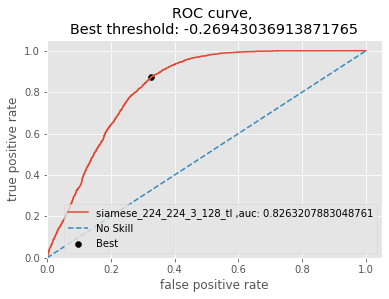

In [386]:
plot_triplet_roc_curve_2(siamese_224_224_3_128_tl, test_dataset, "siamese_224_224_3_128_tl", 128)

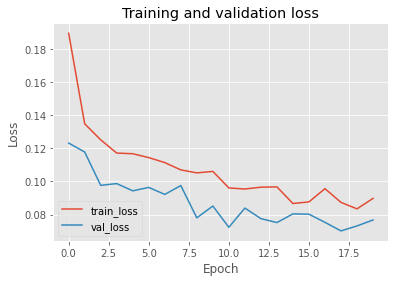

In [387]:
plot_triplet_training(history_siamese_224_224_3_128_tl)

In [398]:
siamese_224_224_3_128_tl.save('saved_models/siamese_224_224_3_128_tl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_128_tl/assets


## Patches 224x224x3, Embedding Size = 256

In [389]:
history_siamese_224_224_3_256_tl, siamese_224_224_3_256_tl = create_siamese_model_triplet_loss(224,224,3, 256, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 29s 504ms/step - loss: 0.2107 - val_loss: 0.1519
Epoch 2/20
56/56 [==============================] - 28s 500ms/step - loss: 0.1606 - val_loss: 0.1208
Epoch 3/20
56/56 [==============================] - 28s 492ms/step - loss: 0.1404 - val_loss: 0.1152
Epoch 4/20
56/56 [==============================] - 28s 503ms/step - loss: 0.1271 - val_loss: 0.1004
Epoch 5/20
56/56 [==============================] - 28s 500ms/step - loss: 0.1246 - val_loss: 0.1120
Epoch 6/20
56/56 [==============================] - 28s 495ms/step - loss: 0.1202 - val_loss: 0.0947
Epoch 7/20
56/56 [==============================] - 27s 484ms/step - loss: 0.1149 - val_loss: 0.0970
Epoch 8/20
56/56 [==============================] - 29s 508ms/step - loss: 0.1092 - val_loss: 0.0972
Epoch 9/20
56/56 [==============================] - 28s 503ms/step - loss: 0.1134 - val_loss: 0.0951
Epoch 10/20
56/56 [==============================] - 28s 501ms/step - loss: 0.1032 - val_lo

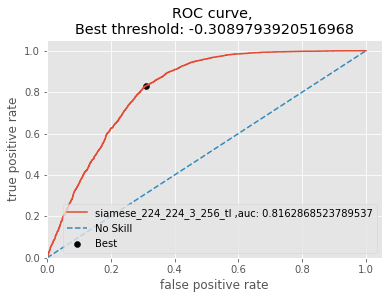

In [390]:
plot_triplet_roc_curve_2(siamese_224_224_3_256_tl, test_dataset, "siamese_224_224_3_256_tl", 256)

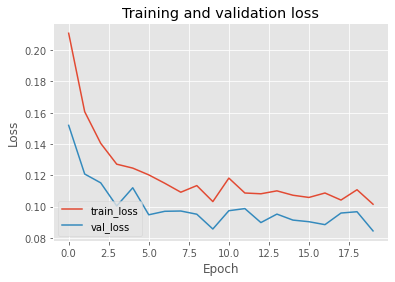

In [391]:
plot_triplet_training(history_siamese_224_224_3_256_tl)

In [399]:
siamese_224_224_3_256_tl.save('saved_models/siamese_224_224_3_256_tl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_256_tl/assets


## Patches 224x224x3, Embedding Size = 512

In [394]:
history_siamese_224_224_3_512_tl, siamese_224_224_3_512_tl = create_siamese_model_triplet_loss(224,224,3, 512, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 28s 485ms/step - loss: 0.1993 - val_loss: 0.1409
Epoch 2/20
56/56 [==============================] - 28s 494ms/step - loss: 0.1581 - val_loss: 0.1245
Epoch 3/20
56/56 [==============================] - 28s 507ms/step - loss: 0.1462 - val_loss: 0.1204
Epoch 4/20
56/56 [==============================] - 29s 510ms/step - loss: 0.1342 - val_loss: 0.1257
Epoch 5/20
56/56 [==============================] - 29s 517ms/step - loss: 0.1330 - val_loss: 0.1167
Epoch 6/20
56/56 [==============================] - 28s 500ms/step - loss: 0.1238 - val_loss: 0.1304
Epoch 7/20
56/56 [==============================] - 27s 488ms/step - loss: 0.1262 - val_loss: 0.1142
Epoch 8/20
56/56 [==============================] - 27s 479ms/step - loss: 0.1244 - val_loss: 0.1178
Epoch 9/20
56/56 [==============================] - 27s 481ms/step - loss: 0.1254 - val_loss: 0.1117
Epoch 10/20
56/56 [==============================] - 27s 480ms/step - loss: 0.1197 - val_lo

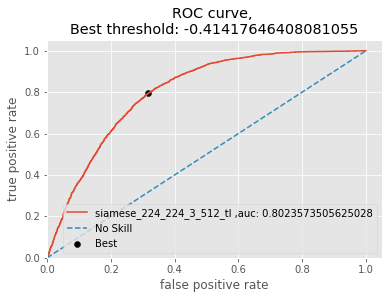

In [395]:
plot_triplet_roc_curve_2(siamese_224_224_3_512_tl, test_dataset, "siamese_224_224_3_512_tl", 512)

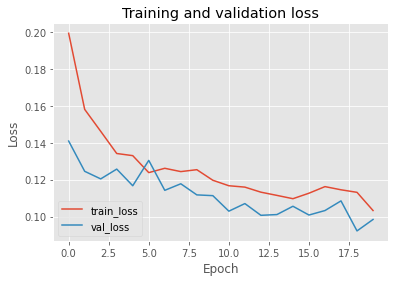

In [396]:
plot_triplet_training(history_siamese_224_224_3_512_tl)

In [401]:
siamese_224_224_3_512_tl.save('saved_models/siamese_224_224_3_512_tl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_512_tl/assets


## Patches 224x224, Embedding Size = 128

In [ ]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=False)

anchor_images_path = "npz_datasets/test_pairs_224_224/anchor"
positive_images_path = "npz_datasets/test_pairs_224_224/positive"
width, height = 224, 224
test_dataset = create_tf_data_testset_triplet(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=False)

In [102]:
siamese_224_224_128.save('saved_models/half_deep_writer_224_224_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


## Patches 224x224, Embedding Size = 256

In [110]:
siamese_224_224_256.save('saved_models/half_deep_writer_224_224_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


## Patches 224x224, Embedding Size = 512

In [14]:
siamese_224_224_512.save('saved_models/half_deep_writer_224_224_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_512/assets


## Patches 113x113x3, Embedding Size = 128

In [41]:
siamese_113_113_3_128.save('saved_models/half_deep_writer_113_113_3_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_128/assets


## Patches 113x113x3, Embedding Size = 256

In [49]:
siamese_113_113_3_256.save('saved_models/half_deep_writer_113_113_3_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_256/assets


## Patches 113x113x3, Embedding Size = 512

In [57]:
siamese_113_113_3_512.save('saved_models/half_deep_writer_113_113_3_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_3_512/assets


## Patches 113x113, Embedding Size = 128

In [82]:
siamese_113_113_128.save('saved_models/half_deep_writer_113_113_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_128/assets


## Patches 113x113, Embedding Size = 256

In [83]:
siamese_113_113_256.save('saved_models/half_deep_writer_113_113_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_256/assets


## Patches 113x113, Embedding Size = 512

In [84]:
siamese_113_113_512.save('saved_models/half_deep_writer_113_113_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_113_113_512/assets


# Contrastive Loss

## Patches 224x224x3, Embedding Size = 128

In [322]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=True)

anchor_images_path = "npz_datasets/test_pairs_224_224/anchor"
positive_images_path = "npz_datasets/test_pairs_224_224/positive"
width, height = 224, 224
test_dataset = create_tf_data_testset_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=True)

In [149]:
def create_siamese_model_contrastive_loss(height, width, channels, emb_size, train_dataset, val_dataset, epochs):

    input_shape = (height,width,channels)
    emb_size = emb_size
    embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

    anchor_input = keras.layers.Input(shape=input_shape)
    pos_neg_input = keras.layers.Input(shape=input_shape)

    feat_vect_a = embedding_half_deep_writer(anchor_input)
    feat_vect_b = embedding_half_deep_writer(pos_neg_input)

    distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
    normal = keras.layers.BatchNormalization()(distance)
    outputs = keras.layers.Dense(1, activation="sigmoid")(normal)

    siamese_model = keras.models.Model(inputs=[anchor_input,pos_neg_input],
                                      outputs=outputs)

    siamese_model.compile(loss=contrastive_loss, optimizer="Adam", metrics="accuracy")

    history_siamese_model = siamese_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    return history_siamese_model, siamese_model

In [9]:
history_siamese_224_224_3_128_cl, siamese_224_224_3_128_cl = create_siamese_model_contrastive_loss(224,224,3, 128, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 22s 338ms/step - loss: 0.3008 - accuracy: 0.5274 - val_loss: 0.4779 - val_accuracy: 0.4925
Epoch 2/20
56/56 [==============================] - 21s 329ms/step - loss: 0.2435 - accuracy: 0.6023 - val_loss: 0.2093 - val_accuracy: 0.6772
Epoch 3/20
56/56 [==============================] - 21s 331ms/step - loss: 0.2288 - accuracy: 0.6287 - val_loss: 0.2046 - val_accuracy: 0.6917
Epoch 4/20
56/56 [==============================] - 21s 346ms/step - loss: 0.2100 - accuracy: 0.6683 - val_loss: 0.2417 - val_accuracy: 0.6353
Epoch 5/20
56/56 [==============================] - 21s 334ms/step - loss: 0.2040 - accuracy: 0.6874 - val_loss: 0.1913 - val_accuracy: 0.7046
Epoch 6/20
56/56 [==============================] - 20s 321ms/step - loss: 0.1974 - accuracy: 0.7038 - val_loss: 0.1824 - val_accuracy: 0.7267
Epoch 7/20
56/56 [==============================] - 19s 319ms/step - loss: 0.1918 - accuracy: 0.7159 - val_loss: 0.1737 - val_accuracy: 0.7415

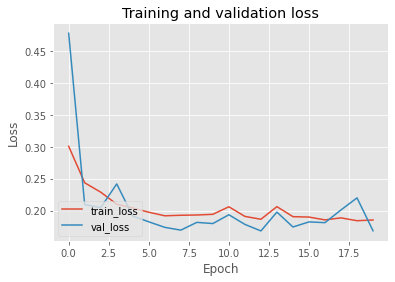

In [10]:
plot_triplet_training(history_siamese_224_224_3_128_cl)

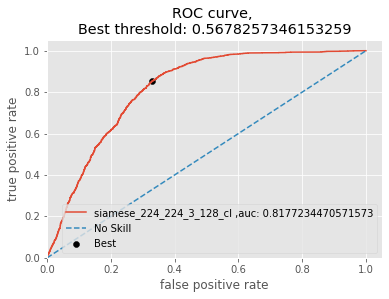

CPU times: user 2min 40s, sys: 5.88 s, total: 2min 46s
Wall time: 2min 26s


In [136]:
plot_contrastive_roc_curve(siamese_224_224_3_128_cl, test_dataset, "siamese_224_224_3_128_cl")

In [199]:
siamese_224_224_3_128_cl.save('saved_models/siamese_224_224_3_128_cl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_128_cl/assets


## Patches 224x224x3, Embedding Size = 256

In [139]:
history_siamese_224_224_3_256_cl, siamese_224_224_3_256_cl = create_siamese_model_contrastive_loss(224,224,3, 256, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 20s 334ms/step - loss: 0.2855 - accuracy: 0.5321 - val_loss: 0.2971 - val_accuracy: 0.5970
Epoch 2/20
56/56 [==============================] - 19s 324ms/step - loss: 0.2400 - accuracy: 0.5958 - val_loss: 0.2152 - val_accuracy: 0.6669
Epoch 3/20
56/56 [==============================] - 19s 325ms/step - loss: 0.2190 - accuracy: 0.6447 - val_loss: 0.1962 - val_accuracy: 0.7010
Epoch 4/20
56/56 [==============================] - 19s 324ms/step - loss: 0.2053 - accuracy: 0.6838 - val_loss: 0.1892 - val_accuracy: 0.7208
Epoch 5/20
56/56 [==============================] - 19s 318ms/step - loss: 0.2160 - accuracy: 0.6566 - val_loss: 0.1890 - val_accuracy: 0.7146
Epoch 6/20
56/56 [==============================] - 20s 332ms/step - loss: 0.2001 - accuracy: 0.6941 - val_loss: 0.1958 - val_accuracy: 0.7169
Epoch 7/20
56/56 [==============================] - 20s 337ms/step - loss: 0.1942 - accuracy: 0.7106 - val_loss: 0.1865 - val_accuracy: 0.7295

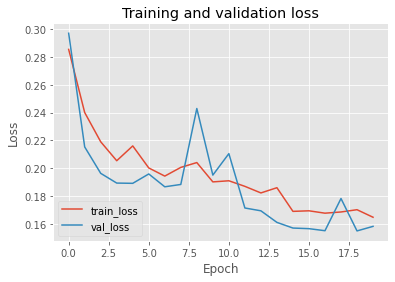

In [140]:
plot_triplet_training(history_siamese_224_224_3_256_cl)

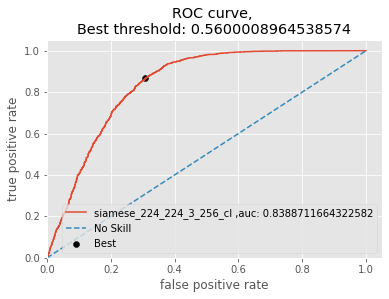

In [143]:
plot_contrastive_roc_curve(siamese_224_224_3_256_cl, test_dataset, "siamese_224_224_3_256_cl")

In [200]:
siamese_224_224_3_256_cl.save('saved_models/siamese_224_224_3_256_cl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_256_cl/assets


## Patches 224x224x3, Embedding Size = 512

In [144]:
history_siamese_224_224_3_512_cl, siamese_224_224_3_512_cl = create_siamese_model_contrastive_loss(224,224,3, 512, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 20s 329ms/step - loss: 0.2595 - accuracy: 0.5321 - val_loss: 0.3180 - val_accuracy: 0.5022
Epoch 2/20
56/56 [==============================] - 19s 324ms/step - loss: 0.2298 - accuracy: 0.6053 - val_loss: 0.2343 - val_accuracy: 0.6372
Epoch 3/20
56/56 [==============================] - 19s 326ms/step - loss: 0.2185 - accuracy: 0.6535 - val_loss: 0.2252 - val_accuracy: 0.6395
Epoch 4/20
56/56 [==============================] - 20s 328ms/step - loss: 0.2129 - accuracy: 0.6729 - val_loss: 0.2001 - val_accuracy: 0.6758
Epoch 5/20
56/56 [==============================] - 20s 328ms/step - loss: 0.2055 - accuracy: 0.6897 - val_loss: 0.1898 - val_accuracy: 0.7236
Epoch 6/20
56/56 [==============================] - 20s 331ms/step - loss: 0.2011 - accuracy: 0.6993 - val_loss: 0.1845 - val_accuracy: 0.7255
Epoch 7/20
56/56 [==============================] - 20s 333ms/step - loss: 0.1989 - accuracy: 0.6994 - val_loss: 0.1847 - val_accuracy: 0.7376

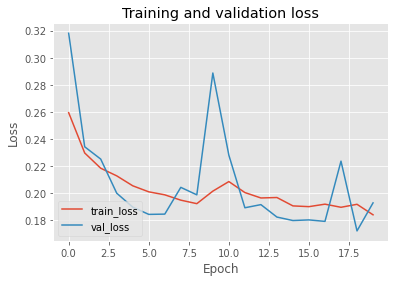

In [145]:
plot_triplet_training(history_siamese_224_224_3_512_cl)

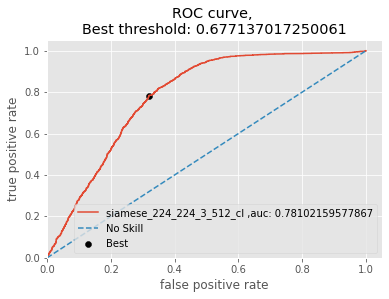

In [146]:
plot_contrastive_roc_curve(siamese_224_224_3_512_cl, test_dataset, "siamese_224_224_3_512_cl")

In [201]:
siamese_224_224_3_512_cl.save('saved_models/siamese_224_224_3_512_cl',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/siamese_224_224_3_512_cl/assets


## Patches 224x224, Embedding Size = 128

In [203]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=False)

anchor_images_path = "npz_datasets/test_pairs_224_224/anchor"
positive_images_path = "npz_datasets/test_pairs_224_224/positive"
width, height = 224, 224
test_dataset = create_tf_data_testset_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=False)

In [160]:
history_siamese_224_224_128_cl, siamese_224_224_128_cl = create_siamese_model_contrastive_loss(224,224,1, 128, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 18s 296ms/step - loss: 0.2497 - accuracy: 0.5230 - val_loss: 0.2367 - val_accuracy: 0.6040
Epoch 2/20
56/56 [==============================] - 16s 286ms/step - loss: 0.2396 - accuracy: 0.5824 - val_loss: 0.2286 - val_accuracy: 0.6294
Epoch 3/20
56/56 [==============================] - 17s 288ms/step - loss: 0.2314 - accuracy: 0.6278 - val_loss: 0.2198 - val_accuracy: 0.6350
Epoch 4/20
56/56 [==============================] - 16s 277ms/step - loss: 0.2232 - accuracy: 0.6546 - val_loss: 0.2136 - val_accuracy: 0.6492
Epoch 5/20
56/56 [==============================] - 16s 275ms/step - loss: 0.2177 - accuracy: 0.6638 - val_loss: 0.2295 - val_accuracy: 0.6160
Epoch 6/20
56/56 [==============================] - 16s 275ms/step - loss: 0.2136 - accuracy: 0.6659 - val_loss: 0.2224 - val_accuracy: 0.6537
Epoch 7/20
56/56 [==============================] - 16s 273ms/step - loss: 0.2122 - accuracy: 0.6626 - val_loss: 0.2149 - val_accuracy: 0.6501

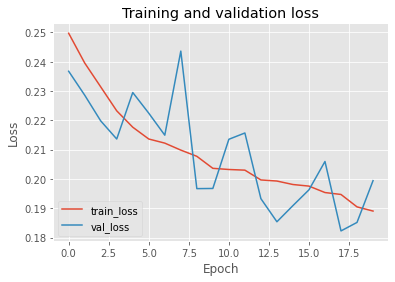

In [161]:
plot_triplet_training(history_siamese_224_224_128_cl)

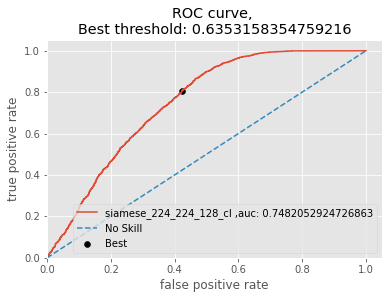

In [204]:
plot_contrastive_roc_curve(siamese_224_224_128_cl, test_dataset, "siamese_224_224_128_cl")

In [205]:
siamese_224_224_128_cl.save('siamese_224_224_128_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_224_224_128_cl/assets


## Patches 224x224, Embedding Size = 256

In [163]:
history_siamese_224_224_256_cl, siamese_224_224_256_cl = create_siamese_model_contrastive_loss(224,224,1, 256, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 18s 302ms/step - loss: 0.2602 - accuracy: 0.5451 - val_loss: 0.2561 - val_accuracy: 0.6042
Epoch 2/20
56/56 [==============================] - 17s 302ms/step - loss: 0.2297 - accuracy: 0.5982 - val_loss: 0.2295 - val_accuracy: 0.6202
Epoch 3/20
56/56 [==============================] - 17s 302ms/step - loss: 0.2190 - accuracy: 0.6403 - val_loss: 0.2090 - val_accuracy: 0.6638
Epoch 4/20
56/56 [==============================] - 17s 301ms/step - loss: 0.2159 - accuracy: 0.6527 - val_loss: 0.1995 - val_accuracy: 0.6828
Epoch 5/20
56/56 [==============================] - 17s 302ms/step - loss: 0.2102 - accuracy: 0.6679 - val_loss: 0.1968 - val_accuracy: 0.6968
Epoch 6/20
56/56 [==============================] - 17s 302ms/step - loss: 0.2096 - accuracy: 0.6650 - val_loss: 0.1974 - val_accuracy: 0.6942
Epoch 7/20
56/56 [==============================] - 17s 302ms/step - loss: 0.2076 - accuracy: 0.6703 - val_loss: 0.2005 - val_accuracy: 0.6906

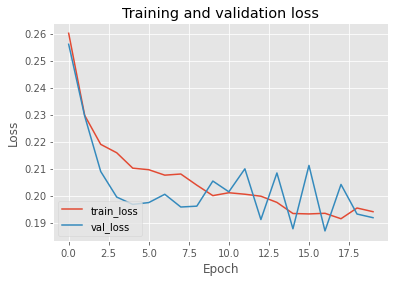

In [164]:
plot_triplet_training(history_siamese_224_224_256_cl)

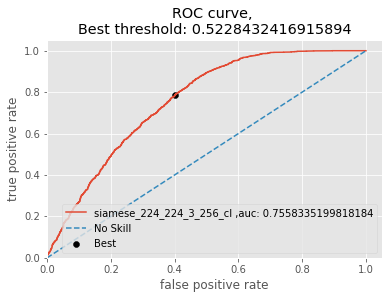

In [165]:
plot_contrastive_roc_curve(siamese_224_224_256_cl, test_dataset, "siamese_224_224_3_256_cl")

In [206]:
siamese_224_224_256_cl.save('siamese_224_224_256_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_224_224_256_cl/assets


## Patches 224x224, Embedding Size = 512

In [166]:
history_siamese_224_224_512_cl, siamese_224_224_512_cl = create_siamese_model_contrastive_loss(224,224,1, 512, train_dataset, val_dataset, 20)

Epoch 1/20
56/56 [==============================] - 18s 302ms/step - loss: 0.2489 - accuracy: 0.5322 - val_loss: 0.2386 - val_accuracy: 0.5998
Epoch 2/20
56/56 [==============================] - 16s 286ms/step - loss: 0.2361 - accuracy: 0.5941 - val_loss: 0.2194 - val_accuracy: 0.6199
Epoch 3/20
56/56 [==============================] - 16s 283ms/step - loss: 0.2264 - accuracy: 0.6410 - val_loss: 0.2237 - val_accuracy: 0.6207
Epoch 4/20
56/56 [==============================] - 17s 304ms/step - loss: 0.2197 - accuracy: 0.6592 - val_loss: 0.2053 - val_accuracy: 0.6750
Epoch 5/20
56/56 [==============================] - 17s 297ms/step - loss: 0.2147 - accuracy: 0.6693 - val_loss: 0.1969 - val_accuracy: 0.6942
Epoch 6/20
56/56 [==============================] - 17s 291ms/step - loss: 0.2107 - accuracy: 0.6728 - val_loss: 0.2105 - val_accuracy: 0.6786
Epoch 7/20
56/56 [==============================] - 17s 292ms/step - loss: 0.2086 - accuracy: 0.6728 - val_loss: 0.2494 - val_accuracy: 0.5959

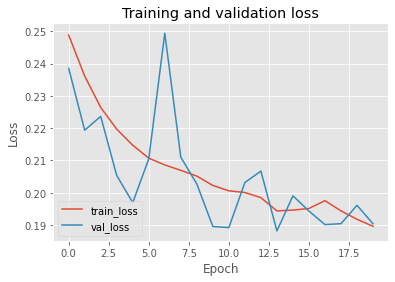

In [167]:
plot_triplet_training(history_siamese_224_224_512_cl)

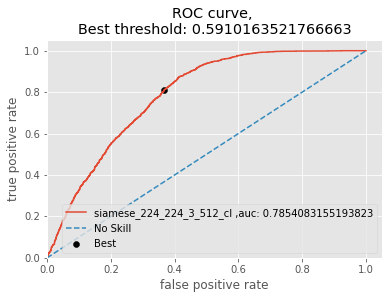

In [168]:
plot_contrastive_roc_curve(siamese_224_224_512_cl, test_dataset, "siamese_224_224_3_512_cl")

In [207]:
siamese_224_224_512_cl.save('siamese_224_224_512_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_224_224_512_cl/assets


## Patches 113x113x3, Embedding Size = 128

In [172]:
anchor_images_path = "npz_datasets/pairs_20k_113_113/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=True)

anchor_images_path = "npz_datasets/test_pairs_113_113/anchor"
positive_images_path = "npz_datasets/test_pairs_113_113/positive"
width, height = 113, 113
test_dataset = create_tf_data_testset_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=True)

In [173]:
history_siamese_113_113_3_128_cl, siamese_113_113_3_128_cl = create_siamese_model_contrastive_loss(113,113,3, 128, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 10s 121ms/step - loss: 0.2824 - accuracy: 0.5271 - val_loss: 0.2849 - val_accuracy: 0.6065
Epoch 2/20
59/59 [==============================] - 5s 85ms/step - loss: 0.2462 - accuracy: 0.5819 - val_loss: 0.2269 - val_accuracy: 0.6391
Epoch 3/20
59/59 [==============================] - 5s 87ms/step - loss: 0.2250 - accuracy: 0.6259 - val_loss: 0.2053 - val_accuracy: 0.6714
Epoch 4/20
59/59 [==============================] - 5s 82ms/step - loss: 0.2106 - accuracy: 0.6653 - val_loss: 0.1993 - val_accuracy: 0.6951
Epoch 5/20
59/59 [==============================] - 5s 86ms/step - loss: 0.2038 - accuracy: 0.6830 - val_loss: 0.1893 - val_accuracy: 0.7109
Epoch 6/20
59/59 [==============================] - 5s 86ms/step - loss: 0.2128 - accuracy: 0.6637 - val_loss: 0.1948 - val_accuracy: 0.7005
Epoch 7/20
59/59 [==============================] - 6s 88ms/step - loss: 0.1988 - accuracy: 0.6942 - val_loss: 0.1937 - val_accuracy: 0.6986
Epoch 8/20


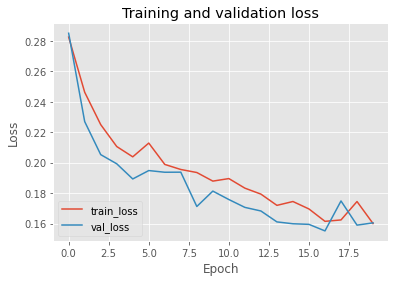

In [174]:
plot_triplet_training(history_siamese_113_113_3_128_cl)

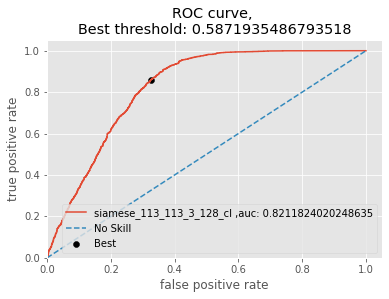

In [175]:
plot_contrastive_roc_curve(siamese_113_113_3_128_cl, test_dataset, "siamese_113_113_3_128_cl")

In [210]:
siamese_113_113_3_128_cl.save('siamese_113_113_3_128_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_3_128_cl/assets


## Patches 113x113x3, Embedding Size = 256

In [177]:
history_siamese_113_113_3_256_cl, siamese_113_113_3_256_cl = create_siamese_model_contrastive_loss(113,113,3, 256, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 6s 88ms/step - loss: 0.2654 - accuracy: 0.5356 - val_loss: 0.2774 - val_accuracy: 0.5894
Epoch 2/20
59/59 [==============================] - 5s 86ms/step - loss: 0.2342 - accuracy: 0.5977 - val_loss: 0.2707 - val_accuracy: 0.6012
Epoch 3/20
59/59 [==============================] - 5s 83ms/step - loss: 0.2244 - accuracy: 0.6261 - val_loss: 0.2174 - val_accuracy: 0.6530
Epoch 4/20
59/59 [==============================] - 5s 85ms/step - loss: 0.2120 - accuracy: 0.6660 - val_loss: 0.2189 - val_accuracy: 0.6479
Epoch 5/20
59/59 [==============================] - 5s 82ms/step - loss: 0.2090 - accuracy: 0.6748 - val_loss: 0.2625 - val_accuracy: 0.5190
Epoch 6/20
59/59 [==============================] - 5s 85ms/step - loss: 0.2059 - accuracy: 0.6826 - val_loss: 0.2076 - val_accuracy: 0.6847
Epoch 7/20
59/59 [==============================] - 5s 83ms/step - loss: 0.1966 - accuracy: 0.7108 - val_loss: 0.2038 - val_accuracy: 0.7053
Epoch 8/20
59

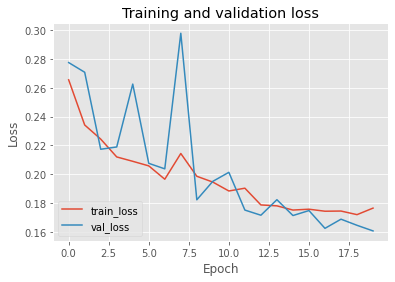

In [178]:
plot_triplet_training(history_siamese_113_113_3_256_cl)

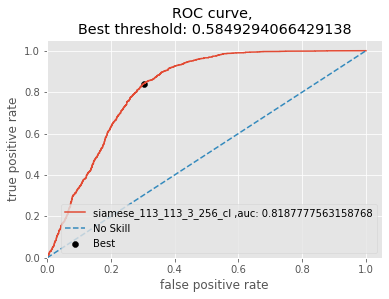

In [179]:
plot_contrastive_roc_curve(siamese_113_113_3_256_cl, test_dataset, "siamese_113_113_3_256_cl")

In [211]:
siamese_113_113_3_256_cl.save('siamese_113_113_3_256_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_3_256_cl/assets


## Patches 113x113x3, Embedding Size = 512

In [180]:
history_siamese_113_113_3_512_cl, siamese_113_113_3_512_cl = create_siamese_model_contrastive_loss(113,113,3, 512, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 6s 87ms/step - loss: 0.2667 - accuracy: 0.5393 - val_loss: 0.3089 - val_accuracy: 0.5483
Epoch 2/20
59/59 [==============================] - 5s 86ms/step - loss: 0.2381 - accuracy: 0.5854 - val_loss: 0.2444 - val_accuracy: 0.6100
Epoch 3/20
59/59 [==============================] - 5s 82ms/step - loss: 0.2232 - accuracy: 0.6294 - val_loss: 0.2469 - val_accuracy: 0.5416
Epoch 4/20
59/59 [==============================] - 5s 83ms/step - loss: 0.2145 - accuracy: 0.6546 - val_loss: 0.2308 - val_accuracy: 0.6089
Epoch 5/20
59/59 [==============================] - 5s 82ms/step - loss: 0.2050 - accuracy: 0.6857 - val_loss: 0.1994 - val_accuracy: 0.7096
Epoch 6/20
59/59 [==============================] - 5s 83ms/step - loss: 0.1983 - accuracy: 0.7026 - val_loss: 0.1820 - val_accuracy: 0.7373
Epoch 7/20
59/59 [==============================] - 5s 81ms/step - loss: 0.1995 - accuracy: 0.6984 - val_loss: 0.2205 - val_accuracy: 0.6618
Epoch 8/20
59

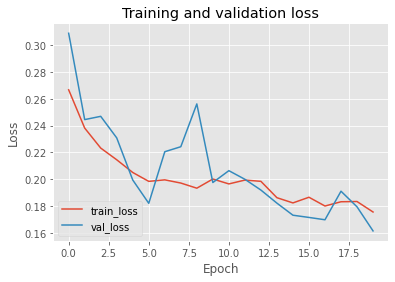

In [181]:
plot_triplet_training(history_siamese_113_113_3_512_cl)

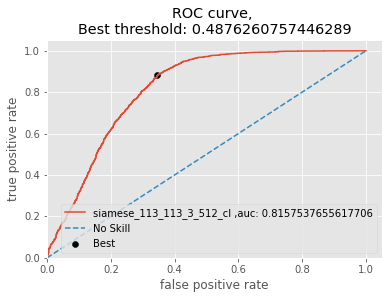

In [182]:
plot_contrastive_roc_curve(siamese_113_113_3_512_cl, test_dataset, "siamese_113_113_3_512_cl")

In [212]:
siamese_113_113_3_512_cl.save('siamese_113_113_3_512_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_3_512_cl/assets


## Patches 113x113, Embedding Size = 128

In [237]:
anchor_images_path = "npz_datasets/pairs_20k_113_113/anchor"
positive_images_path = "npz_datasets/pairs_20k_113_113/positive"
width, height = 113, 113
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size, rgb=False)

anchor_images_path = "npz_datasets/test_pairs_113_113/anchor"
positive_images_path = "npz_datasets/test_pairs_113_113/positive"
width, height = 113, 113
test_dataset = create_tf_data_testset_contrastive(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=False)

In [239]:
history_siamese_113_113_128_cl, siamese_113_113_128_cl = create_siamese_model_contrastive_loss(113,113,1, 128, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2986 - accuracy: 0.5226 - val_loss: 0.4100 - val_accuracy: 0.5347
Epoch 2/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2549 - accuracy: 0.5567 - val_loss: 0.2620 - val_accuracy: 0.5366
Epoch 3/20
59/59 [==============================] - 5s 75ms/step - loss: 0.2488 - accuracy: 0.5872 - val_loss: 0.2834 - val_accuracy: 0.5950
Epoch 4/20
59/59 [==============================] - 5s 75ms/step - loss: 0.2381 - accuracy: 0.6077 - val_loss: 0.2676 - val_accuracy: 0.6052
Epoch 5/20
59/59 [==============================] - 5s 75ms/step - loss: 0.2275 - accuracy: 0.6260 - val_loss: 0.2340 - val_accuracy: 0.6351
Epoch 6/20
59/59 [==============================] - 5s 75ms/step - loss: 0.2191 - accuracy: 0.6453 - val_loss: 0.2102 - val_accuracy: 0.6682
Epoch 7/20
59/59 [==============================] - 5s 75ms/step - loss: 0.2101 - accuracy: 0.6654 - val_loss: 0.1999 - val_accuracy: 0.6935
Epoch 8/20
59

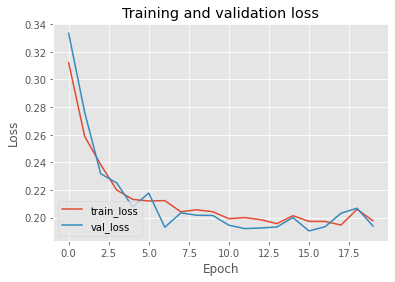

In [186]:
plot_triplet_training(history_siamese_113_113_128_cl)

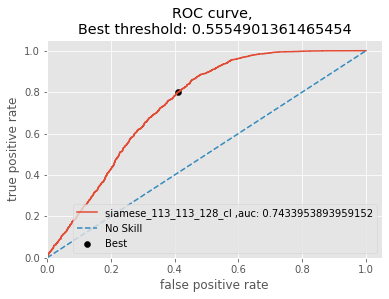

In [187]:
plot_contrastive_roc_curve(siamese_113_113_128_cl, test_dataset, "siamese_113_113_128_cl")

In [213]:
siamese_113_113_128_cl.save('siamese_113_113_128_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_128_cl/assets


## Patches 113x113, Embedding Size = 256

In [193]:
history_siamese_113_113_256_cl, siamese_113_113_256_cl = create_siamese_model_contrastive_loss(113,113,1, 256, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2786 - accuracy: 0.5233 - val_loss: 0.3157 - val_accuracy: 0.4936
Epoch 2/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2591 - accuracy: 0.5693 - val_loss: 0.2257 - val_accuracy: 0.6327
Epoch 3/20
59/59 [==============================] - 5s 73ms/step - loss: 0.2205 - accuracy: 0.6379 - val_loss: 0.2212 - val_accuracy: 0.6514
Epoch 4/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2101 - accuracy: 0.6577 - val_loss: 0.2081 - val_accuracy: 0.6789
Epoch 5/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2046 - accuracy: 0.6657 - val_loss: 0.2033 - val_accuracy: 0.6887
Epoch 6/20
59/59 [==============================] - 5s 72ms/step - loss: 0.2049 - accuracy: 0.6712 - val_loss: 0.2060 - val_accuracy: 0.6751
Epoch 7/20
59/59 [==============================] - 5s 72ms/step - loss: 0.2055 - accuracy: 0.6688 - val_loss: 0.1997 - val_accuracy: 0.6850
Epoch 8/20
59

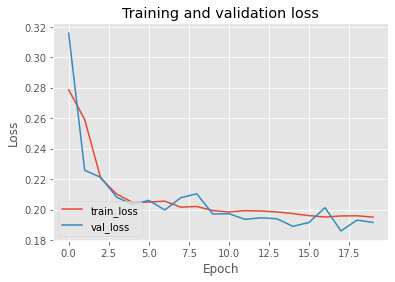

In [194]:
plot_triplet_training(history_siamese_113_113_256_cl)

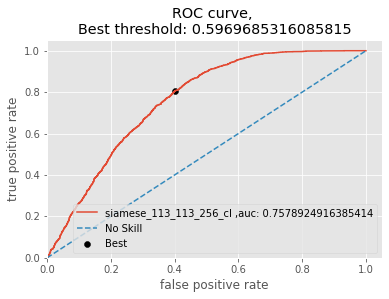

In [195]:
plot_contrastive_roc_curve(siamese_113_113_256_cl, test_dataset, "siamese_113_113_256_cl")

In [224]:
siamese_113_113_256_cl.save('siamese_113_113_256_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_256_cl/assets


## Patches 113x113, Embedding Size = 512

In [196]:
history_siamese_113_113_512_cl, siamese_113_113_512_cl = create_siamese_model_contrastive_loss(113,113,1, 512, train_dataset, val_dataset, 20)

Epoch 1/20
59/59 [==============================] - 6s 76ms/step - loss: 0.2545 - accuracy: 0.5494 - val_loss: 0.3119 - val_accuracy: 0.5454
Epoch 2/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2283 - accuracy: 0.6137 - val_loss: 0.2403 - val_accuracy: 0.6022
Epoch 3/20
59/59 [==============================] - 5s 72ms/step - loss: 0.2237 - accuracy: 0.6285 - val_loss: 0.2139 - val_accuracy: 0.6610
Epoch 4/20
59/59 [==============================] - 5s 72ms/step - loss: 0.2153 - accuracy: 0.6511 - val_loss: 0.2111 - val_accuracy: 0.6458
Epoch 5/20
59/59 [==============================] - 5s 72ms/step - loss: 0.2133 - accuracy: 0.6571 - val_loss: 0.2352 - val_accuracy: 0.6172
Epoch 6/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2114 - accuracy: 0.6610 - val_loss: 0.2044 - val_accuracy: 0.6700
Epoch 7/20
59/59 [==============================] - 5s 74ms/step - loss: 0.2073 - accuracy: 0.6705 - val_loss: 0.1994 - val_accuracy: 0.6922
Epoch 8/20
59

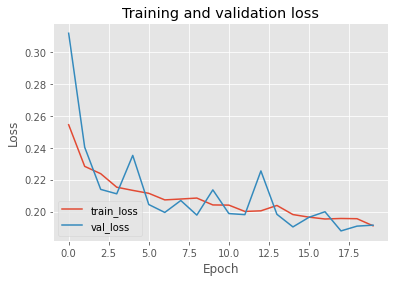

In [197]:
plot_triplet_training(history_siamese_113_113_512_cl)

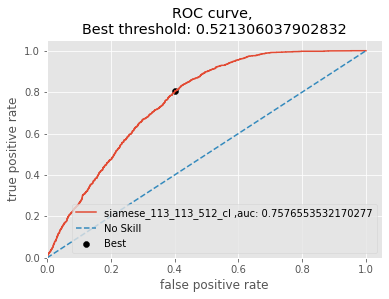

In [198]:
plot_contrastive_roc_curve(siamese_113_113_512_cl, test_dataset, "siamese_113_113_512_cl")

In [215]:
siamese_113_113_512_cl.save('siamese_113_113_512_cl',save_format='tf')

INFO:tensorflow:Assets written to: siamese_113_113_512_cl/assets


# Load and test models

## Triplet loss

In [263]:
anchor_images_path = "npz_datasets/test_pairs_113_113/anchor"
positive_images_path = "npz_datasets/test_pairs_113_113/positive"
width, height = 113, 113
test_dataset = create_tf_data_testset_triplet(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, rgb=True)

In [254]:
triplet_113_113_3_128 = keras.models.load_model('saved_models/half_deep_writer_113_113_3_128')